# MVP

## New car prices and features in the Gulf countries and Egypt.
#### Countries included: Saudi Arabia, United Arab Emirate, Kuwait, Bahrain, Qatar, Oman and Egypt.
##### The data in gather from the websites https://ksa.yallamotor.com/,  https://usa.yallamotor.com/,  https://qatar.yallamotor.com/, https://oman.yallamotor.com/,  https://bahrain.yallamotor.com/,  https://egypt.yallamotor.com/, https://kuwait.yallamotor.com/.
### The process:
##### 1) we visit each country's site. 
##### 2) gather all the links to all cars in all pages.
##### 3) move to the next country.
##### 4) Once done use all the links gathered to extract/scrape the data.

### Importing the libs

In [36]:
import requests
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup  
from selenium import webdriver
import copy
import random
from collections import defaultdict
import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline


### Connecting to the website

In [2]:
url = 'https://ksa.yallamotor.com/new-cars/search'

driver = webdriver.Firefox(executable_path=r'geckodriver/geckodriver.exe')

driver.get(url)
page = driver.page_source
soup = BeautifulSoup(page,'html.parser')

<ipython-input-2-f7d6a1f80ceb>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path=r'geckodriver/geckodriver.exe')


##### Gets the urls of the cars and attach it to the main url

In [3]:
all_ksa_urls = []
def getUrls(urls, link_location='rightbuttons',main_tag='div',link_tag='class',master_link='https://ksa.yallamotor.com'):
    items= soup.find_all(main_tag, attrs={link_tag:link_location})
    for i in range(len(items)):
        urls.append(master_link+items[i].a['href'])
    urls = copy.deepcopy(list(set(urls)))#removing duplicated links
    return urls

##### Testing and see the URL obtained.

In [4]:
all_ksa_urls = getUrls(all_ksa_urls)
print('length of initial urls:', len(all_ksa_urls))
all_ksa_urls

length of initial urls: 15


['https://ksa.yallamotor.com/new-cars/peugeot/expert/van-l3-m-t',
 'https://ksa.yallamotor.com/new-cars/peugeot/expert/van-l3-a-t',
 'https://ksa.yallamotor.com/new-cars/suzuki/jimny/1-5l-m-t',
 'https://ksa.yallamotor.com/new-cars/fiat/500e/la-prima',
 'https://ksa.yallamotor.com/new-cars/peugeot/traveller/l3-vip',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-ex',
 'https://ksa.yallamotor.com/new-cars/renault/koleos/2-5l-le-4wd',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-dx',
 'https://ksa.yallamotor.com/new-cars/suzuki/jimny/1-5l-automatic',
 'https://ksa.yallamotor.com/new-cars/peugeot/2008/1-2t-allure-155hp',
 'https://ksa.yallamotor.com/new-cars/ford/bronco/2-7t-outer-banks',
 'https://ksa.yallamotor.com/new-cars/ford/bronco/2-3t-big-bend',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-lx',
 'https://ksa.yallamotor.com/new-cars/gmc/yukon-xl/5-3l-v8-slt-awd',
 'https://ksa.yallamotor.com/new-cars/gac/gs3/1-3t-ge']

##### This function is to move through the main pages to collect the urls

In [5]:
def Move(i,country='ksa'): 
    global soup  
    new_url = f"https://{country}.yallamotor.com/new-cars/search?page={i}&sort=price_asc"
    driver.get(new_url)
    
    page = driver.page_source
    soup = BeautifulSoup(page,'html.parser')
    return new_url

##### Testing the Seed to start the movement and to mark the starting page

In [6]:
all_ksa_urls = []

driver.get(url)
page = driver.page_source
soup = BeautifulSoup(page,'html.parser')
all_ksa_urls = getUrls(all_ksa_urls)
print('length of initial urls:', len(all_ksa_urls))
all_ksa_urls

length of initial urls: 15


['https://ksa.yallamotor.com/new-cars/peugeot/expert/van-l3-m-t',
 'https://ksa.yallamotor.com/new-cars/peugeot/expert/van-l3-a-t',
 'https://ksa.yallamotor.com/new-cars/suzuki/jimny/1-5l-m-t',
 'https://ksa.yallamotor.com/new-cars/fiat/500e/la-prima',
 'https://ksa.yallamotor.com/new-cars/peugeot/traveller/l3-vip',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-ex',
 'https://ksa.yallamotor.com/new-cars/renault/koleos/2-5l-le-4wd',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-dx',
 'https://ksa.yallamotor.com/new-cars/suzuki/jimny/1-5l-automatic',
 'https://ksa.yallamotor.com/new-cars/peugeot/2008/1-2t-allure-155hp',
 'https://ksa.yallamotor.com/new-cars/ford/bronco/2-7t-outer-banks',
 'https://ksa.yallamotor.com/new-cars/ford/bronco/2-3t-big-bend',
 'https://ksa.yallamotor.com/new-cars/honda/hr-v/1-8-i-vtec-lx',
 'https://ksa.yallamotor.com/new-cars/gmc/yukon-xl/5-3l-v8-slt-awd',
 'https://ksa.yallamotor.com/new-cars/gac/gs3/1-3t-ge']

##### Getting all the URLs when reaches the end of the list of sites, ends with and error.

In [7]:
def scrape(theURLS,max_pages=84, moving_link='starting',i=2, country='ksa', master_link='https://ksa.yallamotor.com',update=10, progress = 1):
    global url
    print(url)
    #Seed to starting the movement and to mark the starting page        
    driver.get(url)
    page = driver.page_source
    soup = BeautifulSoup(page,'html.parser')
    theURLS = getUrls(theURLS,master_link=master_link)
    print('length of initial urls:', len(theURLS))
    
    while(True):
        try:
            moving_link = Move(i,country=country)
            if not i % update:
                print("At:", moving_link)
            theURLS = getUrls(theURLS,master_link=master_link)
            if not i % update:
                print('Num of urls:', len(theURLS))
            if not i % progress:
                print("Done", i)
            i +=1
            if i == max_pages+1:
                print("Total number:", len(theURLS))
                return theURLS
        except ValueError as e:
            print(e)

## KSA

In [8]:
url = 'https://ksa.yallamotor.com/new-cars/search'
all_ksa_urls = []
all_ksa_urls = scrape(all_ksa_urls, max_pages=82, update=40, progress = 20)
print("Total cars:", len(all_ksa_urls))
print("Sample links:", all_ksa_urls[:10])

https://ksa.yallamotor.com/new-cars/search
length of initial urls: 15
Done 20
At: https://ksa.yallamotor.com/new-cars/search?page=40&sort=price_asc
Num of urls: 600
Done 40
Done 60
At: https://ksa.yallamotor.com/new-cars/search?page=80&sort=price_asc
Num of urls: 1200
Done 80
Total number: 1217
Total cars: 1217
Sample links: ['https://ksa.yallamotor.com/new-cars/bmw/m4-convertible/3-0t-competition-m-xdrive', 'https://ksa.yallamotor.com/new-cars/land-rover/range-rover/5-0l-v8-vogue-se-525-ps', 'https://ksa.yallamotor.com/new-cars/fiat/500e/la-prima', 'https://ksa.yallamotor.com/new-cars/nissan/patrol/nismo', 'https://ksa.yallamotor.com/new-cars/jaguar/xf/2-0t-s-250-ps', 'https://ksa.yallamotor.com/new-cars/ford/figo/1-5l-trend-h-b', 'https://ksa.yallamotor.com/new-cars/mercedes-benz/g-class/g63', 'https://ksa.yallamotor.com/new-cars/haval/h6/supreme', 'https://ksa.yallamotor.com/new-cars/kia/cadenza/3-3l-gdi-mid', 'https://ksa.yallamotor.com/new-cars/mini/countryman/cooper']


#### Getting the data - the first 250 links.
###### Note because its the (MVP)

In [13]:
def open_link(link): 
    global soup  
    driver.get(link)
    page = driver.page_source
    soup = BeautifulSoup(page,'html.parser')

def get_titles():
    global soup
    return soup.find_all('div', attrs={'class':'col is-7 p0'})

def get_values():
    global soup
    return soup.find_all('div', attrs={'class':'col is-5 p0 font-b'})

def get_rest_of_features():
    global soup
    return soup.find_all('div', attrs={'class':'col is-6 display-flex'})

def add_title_value(data,titles,values):
    for (title, value) in zip(titles,values):
        if title.text not in feature_names:
            continue
        data[title.text].append(value.text)

def add_rest(data,features_current):
    for i in features_current:
        i = i.text.replace('\n','').lstrip(' ')
        if i not in feature_names:
            continue
        data[i].append(1)

def get_max(data):
    max_len = -1
    for k,v in data.items():
        if len(v) > max_len:
            max_len = len(v)
    return max_len

def pad_zero(max_len):
    for k,v in data.items():
        i = 0
        while(len(v) < max_len):
            data[k].append(0)
    return data

def default_feature_from_link(data,feature_names,links='https://ksa.yallamotor.com/new-cars/gmc/yukon-xl/5-3l-v8-slt-awd'):
    link = links
    open_link(link)
    titles = soup.find_all('div', attrs={'class':'col is-7 p0'})
    values = soup.find_all('div', attrs={'class':'col is-5 p0 font-b'})
    features = soup.find_all('div', attrs={'class':'col is-6 display-flex'})
    for title in titles:
        feature_names.append(title.text)
    print("initial number of features:",len(feature_names))
    for i in features:
        feature_names.append(i.text.replace('\n','').lstrip(' '))
    print("total number of features:",len(feature_names))
    for key in feature_names:
        data[key].append(-1)
        
def report(data):
    cols = []
    for key, v in data.items():
        cols.append(key)
        print("Key: len(Values) -> ", key, len(v))
        

def useLinks(data):
    global soup
    counter = 0
    for current_link in dataLinks[:250]:
        
        try:
            link = current_link
            open_link(link)
            titles_current = get_titles()
            values_current = get_values()
            features_current = get_rest_of_features()
            add_title_value(data,titles_current,values_current)
            add_rest(data,features_current)
            
            #adding the car name and country and price
            name = soup.find('h1', attrs={'class':'font24 font-b'})
            try:
                name = name.text.replace('\n','').lstrip(' ')
            except:
                name = f'Null__NAME'
                print('Invalid__Null__NAME', name, link)

            country = link.split('.')[0].split('/')[-1]

            currency_price = soup.find('div', attrs={'class':'m24t font-b font20'})
            try:
                price = currency_price.text.replace('\n','').lstrip(' ').split(' ')[1]
                currency = currency_price.text.replace('\n','').lstrip(' ').split(' ')[0]
            except:
                try:
                    price = currency_price.text.replace('\n','').lstrip(' ')
                    if country  == 'ksa':
                        currency = 'SAR'
                    elif country == 'uae':
                        currency = 'AED'
                    elif country == 'egypt':
                        currency = 'EGP'
                    elif country == 'bahrain':
                        currency = 'BHD'
                    elif country == 'kuwait':
                        currency = 'KWD'
                    elif country == 'oman':
                        currency = 'OMR'
                    elif country == 'qatar':
                        currency = 'QAR'
                    else:
                        currency = country
                except:
                    price = f'Null__PRICE'
                    print('Invalid__Null__PRICE', price, link)
                    currency = country                    

            data['name'].append(name)
            data['price'].append(price)
            data['currency'].append(currency)
            data['country'].append(country)
            
            max_len = get_max(data)
            data = pad_zero(max_len)
            
            counter += 1
            if not counter % 100 or counter == -1:
                print(f"At:{counter}")
                report(data)
            if not counter % 10:
                print('.')
                
        except ValueError as e:
            print("Error occured.... sleeping for 30 second. Error:",e)
            time.sleep(30)
            print("Continuing.")
    


### Selecting the first 250 links as this is MVP.

In [14]:
link = 'https://ksa.yallamotor.com/new-cars/gmc/yukon-xl/5-3l-v8-slt-awd'
open_link(link)

data = defaultdict(list)

feature_names = []
default_feature_from_link(data,feature_names)

dataLinks= copy.deepcopy(all_ksa_urls)
print(dataLinks[:10])

useLinks(data)

initial number of features: 13
total number of features: 81
['https://ksa.yallamotor.com/new-cars/bmw/m4-convertible/3-0t-competition-m-xdrive', 'https://ksa.yallamotor.com/new-cars/land-rover/range-rover/5-0l-v8-vogue-se-525-ps', 'https://ksa.yallamotor.com/new-cars/fiat/500e/la-prima', 'https://ksa.yallamotor.com/new-cars/nissan/patrol/nismo', 'https://ksa.yallamotor.com/new-cars/jaguar/xf/2-0t-s-250-ps', 'https://ksa.yallamotor.com/new-cars/ford/figo/1-5l-trend-h-b', 'https://ksa.yallamotor.com/new-cars/mercedes-benz/g-class/g63', 'https://ksa.yallamotor.com/new-cars/haval/h6/supreme', 'https://ksa.yallamotor.com/new-cars/kia/cadenza/3-3l-gdi-mid', 'https://ksa.yallamotor.com/new-cars/mini/countryman/cooper']
.
.
.
.
.
.
.
.
.
At:100
Key: len(Values) ->  Engine Capacity (liters) 114
Key: len(Values) ->  Cylinders 114
Key: len(Values) ->  Drive Type 114
Key: len(Values) ->  Fuel Type 114
Key: len(Values) ->  Horsepower (bhp) 114
Key: len(Values) ->  Torque (Nm) 114
Key: len(Values) -

### Total MVP data

In [15]:
report(data)

Key: len(Values) ->  Engine Capacity (liters) 273
Key: len(Values) ->  Cylinders 273
Key: len(Values) ->  Drive Type 273
Key: len(Values) ->  Fuel Type 273
Key: len(Values) ->  Horsepower (bhp) 273
Key: len(Values) ->  Torque (Nm) 273
Key: len(Values) ->  Transmission 273
Key: len(Values) ->  Seating Capacity 273
Key: len(Values) ->  Length (meters) 273
Key: len(Values) ->  Width (meters) 273
Key: len(Values) ->  Height (meters) 273
Key: len(Values) ->  Wheelbase (meters) 273
Key: len(Values) ->  Trunk Capacity (liters) 273
Key: len(Values) ->  ABS (Anti-lock Brake System) 273
Key: len(Values) ->  Airbags 273
Key: len(Values) ->  Anti theft alarm 273
Key: len(Values) ->  BA (Brake Assist) 273
Key: len(Values) ->  Collision Detection 273
Key: len(Values) ->  Differential Lock 273
Key: len(Values) ->  EBD (Electronic Brakeforce Distribution) 273
Key: len(Values) ->  Fire Extinguisher 273
Key: len(Values) ->  First Aid Kit 273
Key: len(Values) ->  Gas Shock Absorber 273
Key: len(Values) -

## EDA
The number of features and
The features

In [18]:
print(len(data.keys()))
data.keys()

85


dict_keys(['Engine Capacity (liters)', 'Cylinders', 'Drive Type', 'Fuel Type', 'Horsepower (bhp)', 'Torque (Nm)', 'Transmission', 'Seating Capacity', 'Length (meters)', 'Width (meters)', 'Height (meters)', 'Wheelbase (meters)', 'Trunk Capacity (liters)', 'ABS (Anti-lock Brake System)', 'Airbags', 'Anti theft alarm', 'BA (Brake Assist)', 'Collision Detection', 'Differential Lock', 'EBD (Electronic Brakeforce Distribution)', 'Fire Extinguisher', 'First Aid Kit', 'Gas Shock Absorber', 'Hill Assist', 'Hill Descent Control ', 'Immobilizer', 'ISO Fix Child Seat Anchors', 'Lane Departure Warning', 'Multi Terrain Select', 'Parking Sensors - Front and Rear', 'Pedestrian airbag', 'Rear Camera', 'Surround Camera', 'Tire Pressure Monitoring Display', 'Traction Control', 'Variable Cylinder Management (VCM)', 'Center Arm Rest', 'Central Locking', 'Electric Sunroof', 'Foldable Rear Seats with 60:40 Split', 'Leather Seats', 'Multi Information Display', 'Panoramic Glass Roof', 'Power Steering', 'Rear L

In [20]:
backup = copy.deepcopy(data)
df = pd.DataFrame.from_dict(data)

In [22]:
df.to_csv (r'raw_df_mvp.csv', index = False)

In [23]:
df.head()

,Engine Capacity (liters),Cylinders,Drive Type,Fuel Type,Horsepower (bhp),Torque (Nm),Transmission,Seating Capacity,Length (meters),Width (meters),...,USB,Wireless Headphones,Sell your car 100% absolutely free on YallaMotor.,200+ Cars Sold Everyday.,"115,000+ Satisfied Sellers.","500,000+ Monthly Buyers.",name,price,currency,country
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,BMW M4 Convertible 2021 3.0T Competition M xDrive,"497,200",SAR,ksa
1,3.0,6,All Wheel Drive,Petrol,510,650,Automatic,4 Seater,1.887,1.395,...,1,1,1,1,1,1,0,0,0,0
2,5.0,8,All Wheel Drive,Petrol,525,625,Automatic,5 Seater,2.073,1.869,...,1,0,1,1,1,1,Land Rover Range Rover 2021 5.0L V8 Vogue SE (...,"708,975",SAR,ksa
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,"N/A, Electric",Front Wheel Drive,Electric,117,200,Automatic,4 Seater,2.027,1.488,...,1,0,1,1,1,1,Fiat 500e 2021 La Prima,TBD,SAR,ksa


In [32]:
nulls = df[df.isnull().any(axis=1)]
nulls.head()

,Engine Capacity (liters),Cylinders,Drive Type,Fuel Type,Horsepower (bhp),Torque (Nm),Transmission,Seating Capacity,Length (meters),Width (meters),...,USB,Wireless Headphones,Sell your car 100% absolutely free on YallaMotor.,200+ Cars Sold Everyday.,"115,000+ Satisfied Sellers.","500,000+ Monthly Buyers.",name,price,currency,country


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 85 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Engine Capacity (liters)                           273 non-null    object
 1   Cylinders                                          273 non-null    object
 2   Drive Type                                         273 non-null    object
 3   Fuel Type                                          273 non-null    object
 4   Horsepower (bhp)                                   273 non-null    object
 5   Torque (Nm)                                        273 non-null    object
 6   Transmission                                       273 non-null    object
 7   Seating Capacity                                   273 non-null    object
 8   Length (meters)                                    273 non-null    object
 9   Width (meters)       

In [37]:
df.corr()

,ABS (Anti-lock Brake System),Airbags,Anti theft alarm,BA (Brake Assist),Collision Detection,Differential Lock,EBD (Electronic Brakeforce Distribution),Fire Extinguisher,First Aid Kit,Gas Shock Absorber,...,MP3,Push Button Start,Rain Sensing Wipers,Touchscreen,USB,Wireless Headphones,Sell your car 100% absolutely free on YallaMotor.,200+ Cars Sold Everyday.,"115,000+ Satisfied Sellers.","500,000+ Monthly Buyers."
ABS (Anti-lock Brake System),1.000000,0.760246,0.611982,0.664806,0.112208,0.198770,0.845462,0.052320,0.086274,0.042968,...,0.664750,0.467770,0.311813,0.348021,0.627834,0.042968,0.744916,0.744916,0.744916,0.744916
Airbags,0.760246,1.000000,0.590653,0.495346,0.092496,0.172131,0.672180,0.073574,0.052287,0.064453,...,0.576343,0.370004,0.248476,0.328090,0.542815,0.064453,0.744916,0.744916,0.744916,0.744916
Anti theft alarm,0.611982,0.590653,1.000000,0.491345,0.184654,0.198525,0.674970,0.097619,0.047347,0.117954,...,0.516619,0.433076,0.309718,0.276952,0.532044,0.117954,0.507109,0.507109,0.507109,0.507109
BA (Brake Assist),0.664806,0.495346,0.491345,1.000000,0.071195,0.118948,0.702344,-0.095834,0.024550,-0.078096,...,0.591799,0.587002,0.418524,0.366712,0.585963,-0.078096,0.498956,0.498956,0.498956,0.498956
Collision Detection,0.112208,0.092496,0.184654,0.071195,1.000000,0.301749,0.137080,0.721581,0.385068,0.749461,...,0.031211,0.090204,0.203664,0.057912,0.206364,0.749461,0.175683,0.175683,0.175683,0.175683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wireless Headphones,0.042968,0.064453,0.117954,-0.078096,0.749461,0.322264,0.051336,0.974628,0.422895,1.000000,...,-0.119680,-0.103627,-0.046216,-0.089554,0.053874,1.000000,0.130807,0.130807,0.130807,0.130807
Sell your car 100% absolutely free on YallaMotor.,0.744916,0.744916,0.507109,0.498956,0.175683,0.190082,0.667659,0.136437,0.171348,0.130807,...,0.547397,0.370075,0.246034,0.284976,0.503000,0.130807,1.000000,1.000000,1.000000,1.000000
200+ Cars Sold Everyday.,0.744916,0.744916,0.507109,0.498956,0.175683,0.190082,0.667659,0.136437,0.171348,0.130807,...,0.547397,0.370075,0.246034,0.284976,0.503000,0.130807,1.000000,1.000000,1.000000,1.000000
"115,000+ Satisfied Sellers.",0.744916,0.744916,0.507109,0.498956,0.175683,0.190082,0.667659,0.136437,0.171348,0.130807,...,0.547397,0.370075,0.246034,0.284976,0.503000,0.130807,1.000000,1.000000,1.000000,1.000000


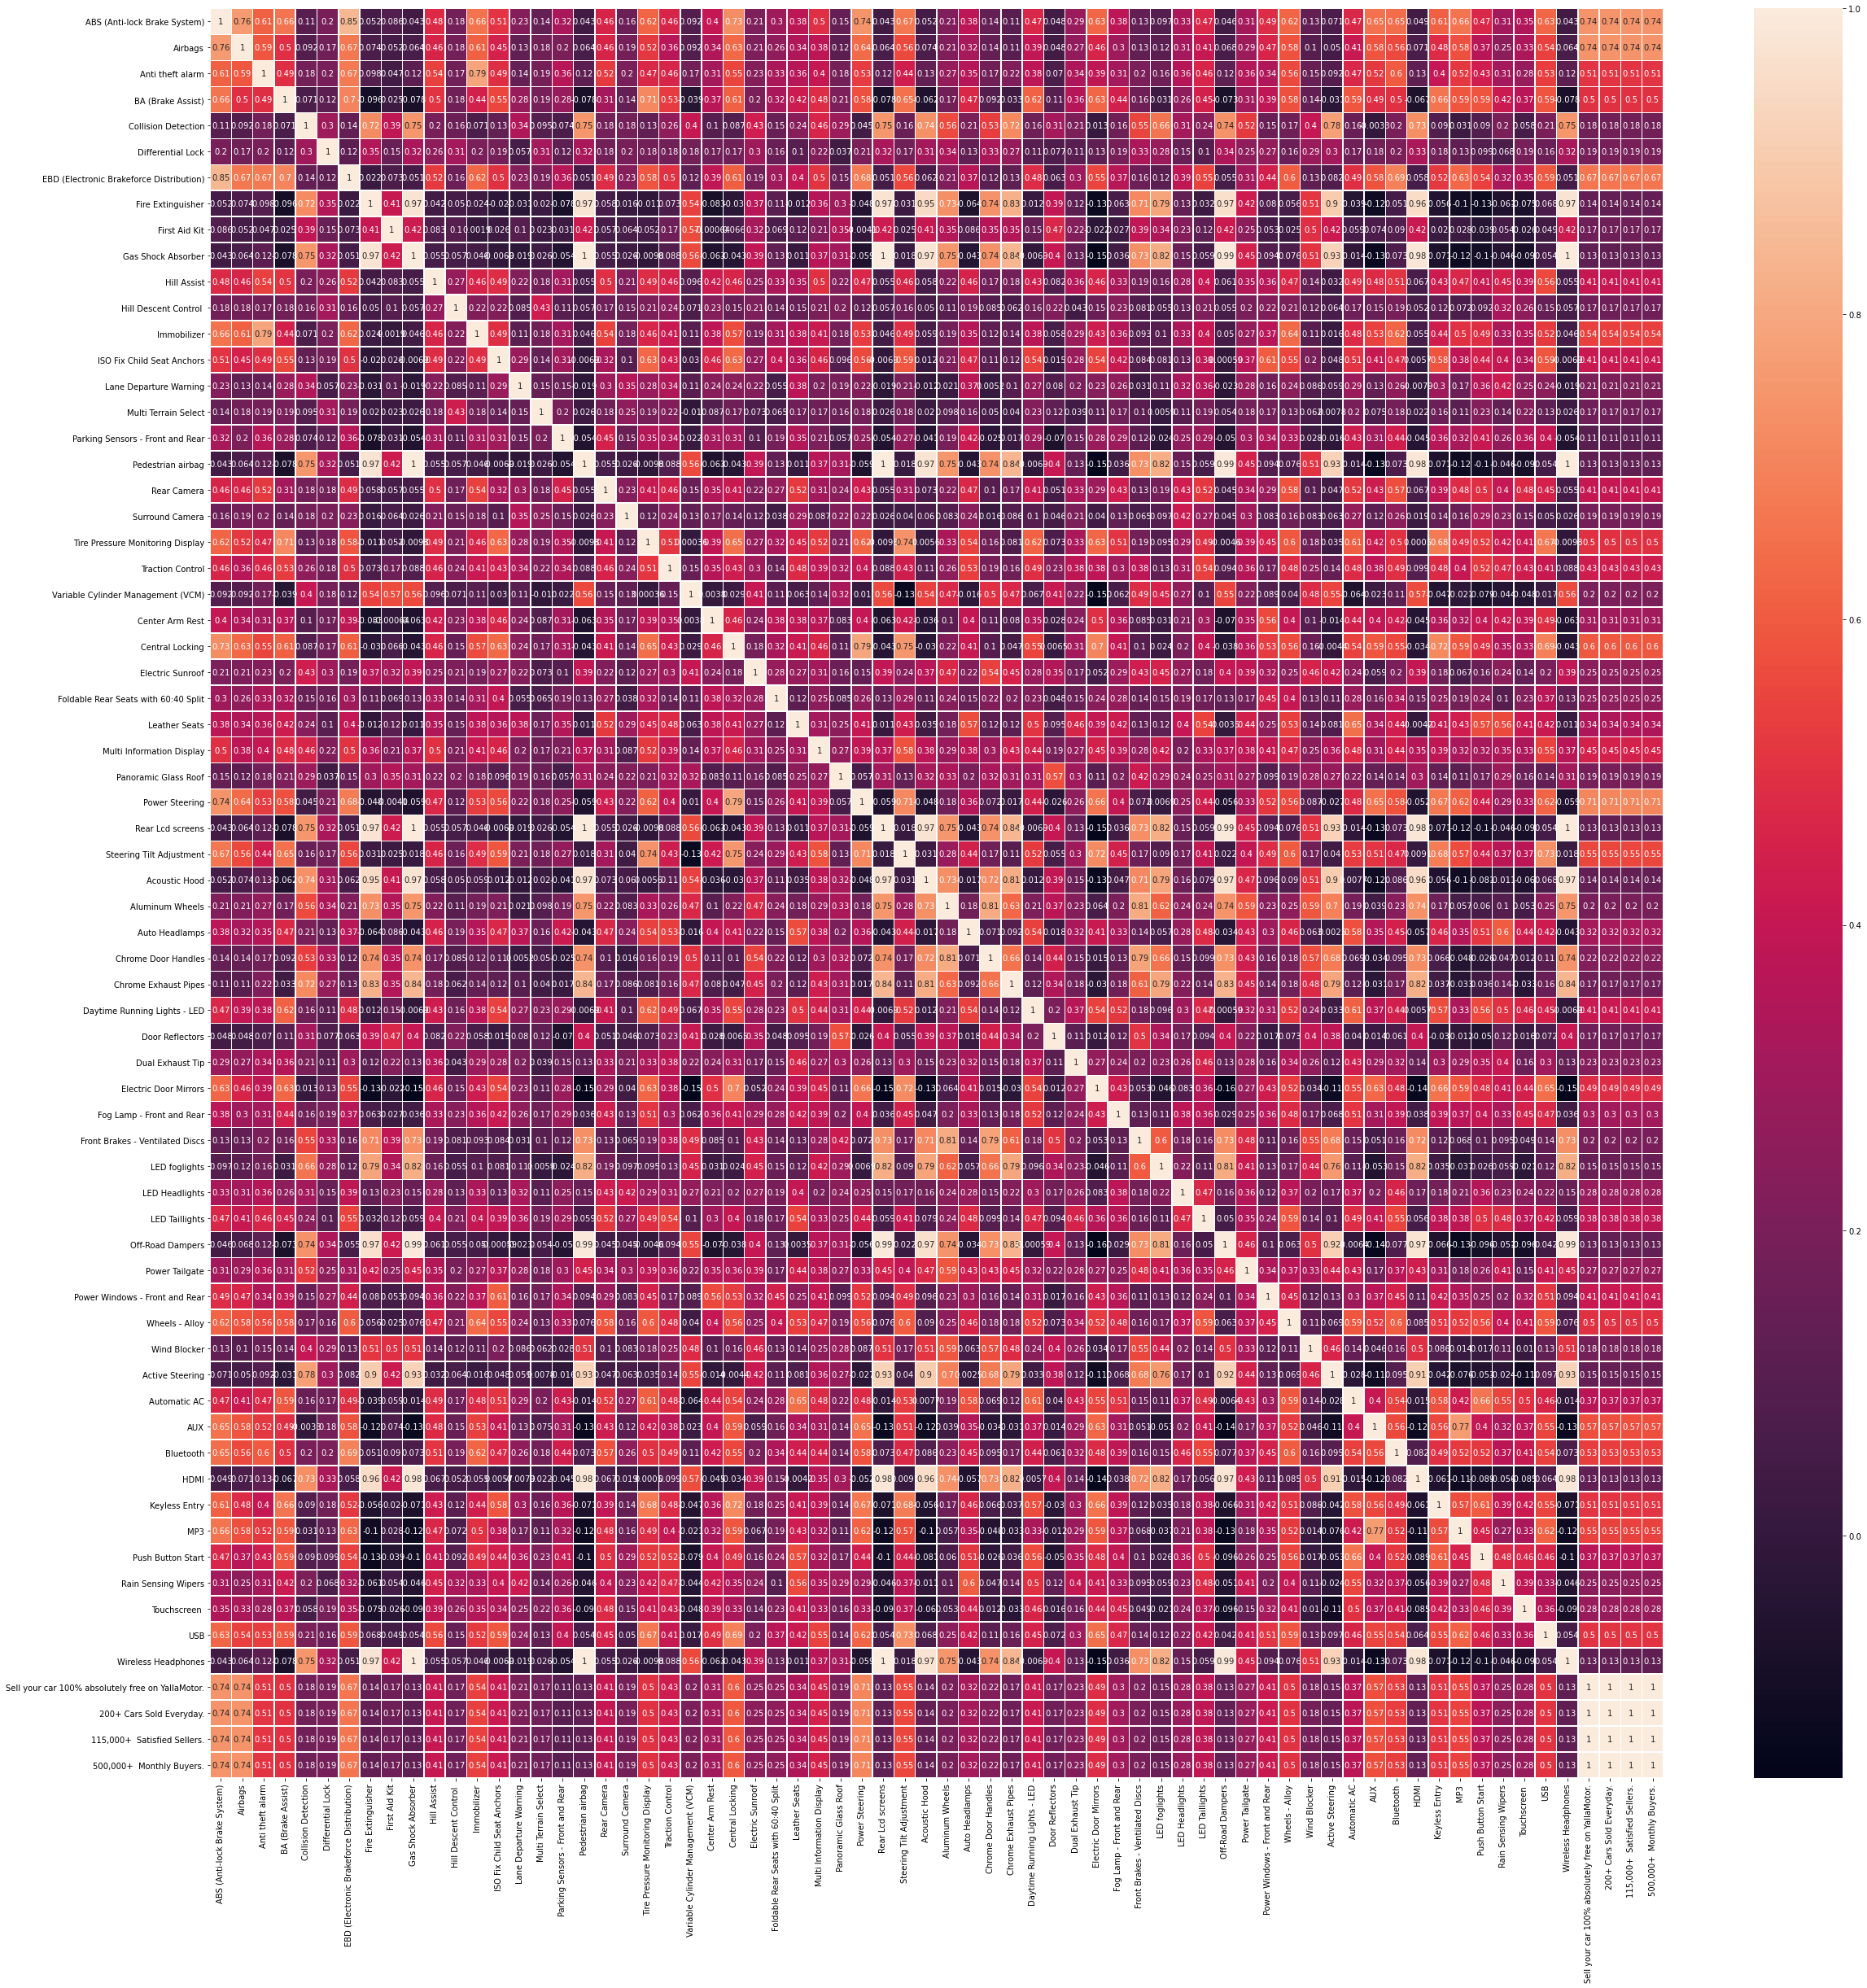

In [50]:
fig, ax = plt.subplots(figsize=(40,40))         # Sample figsize in inches
sns.heatmap(df.corr(), ax=ax, linewidths=0.5, annot=True);

In [71]:
df['price'].replace('TBD','0', inplace = True)
df['price'].replace('DISCONTINUED','0', inplace = True)
df['price'].replace('.','', inplace = True)
df['price'].unique()
df['price'] = df['price'].astype(float)

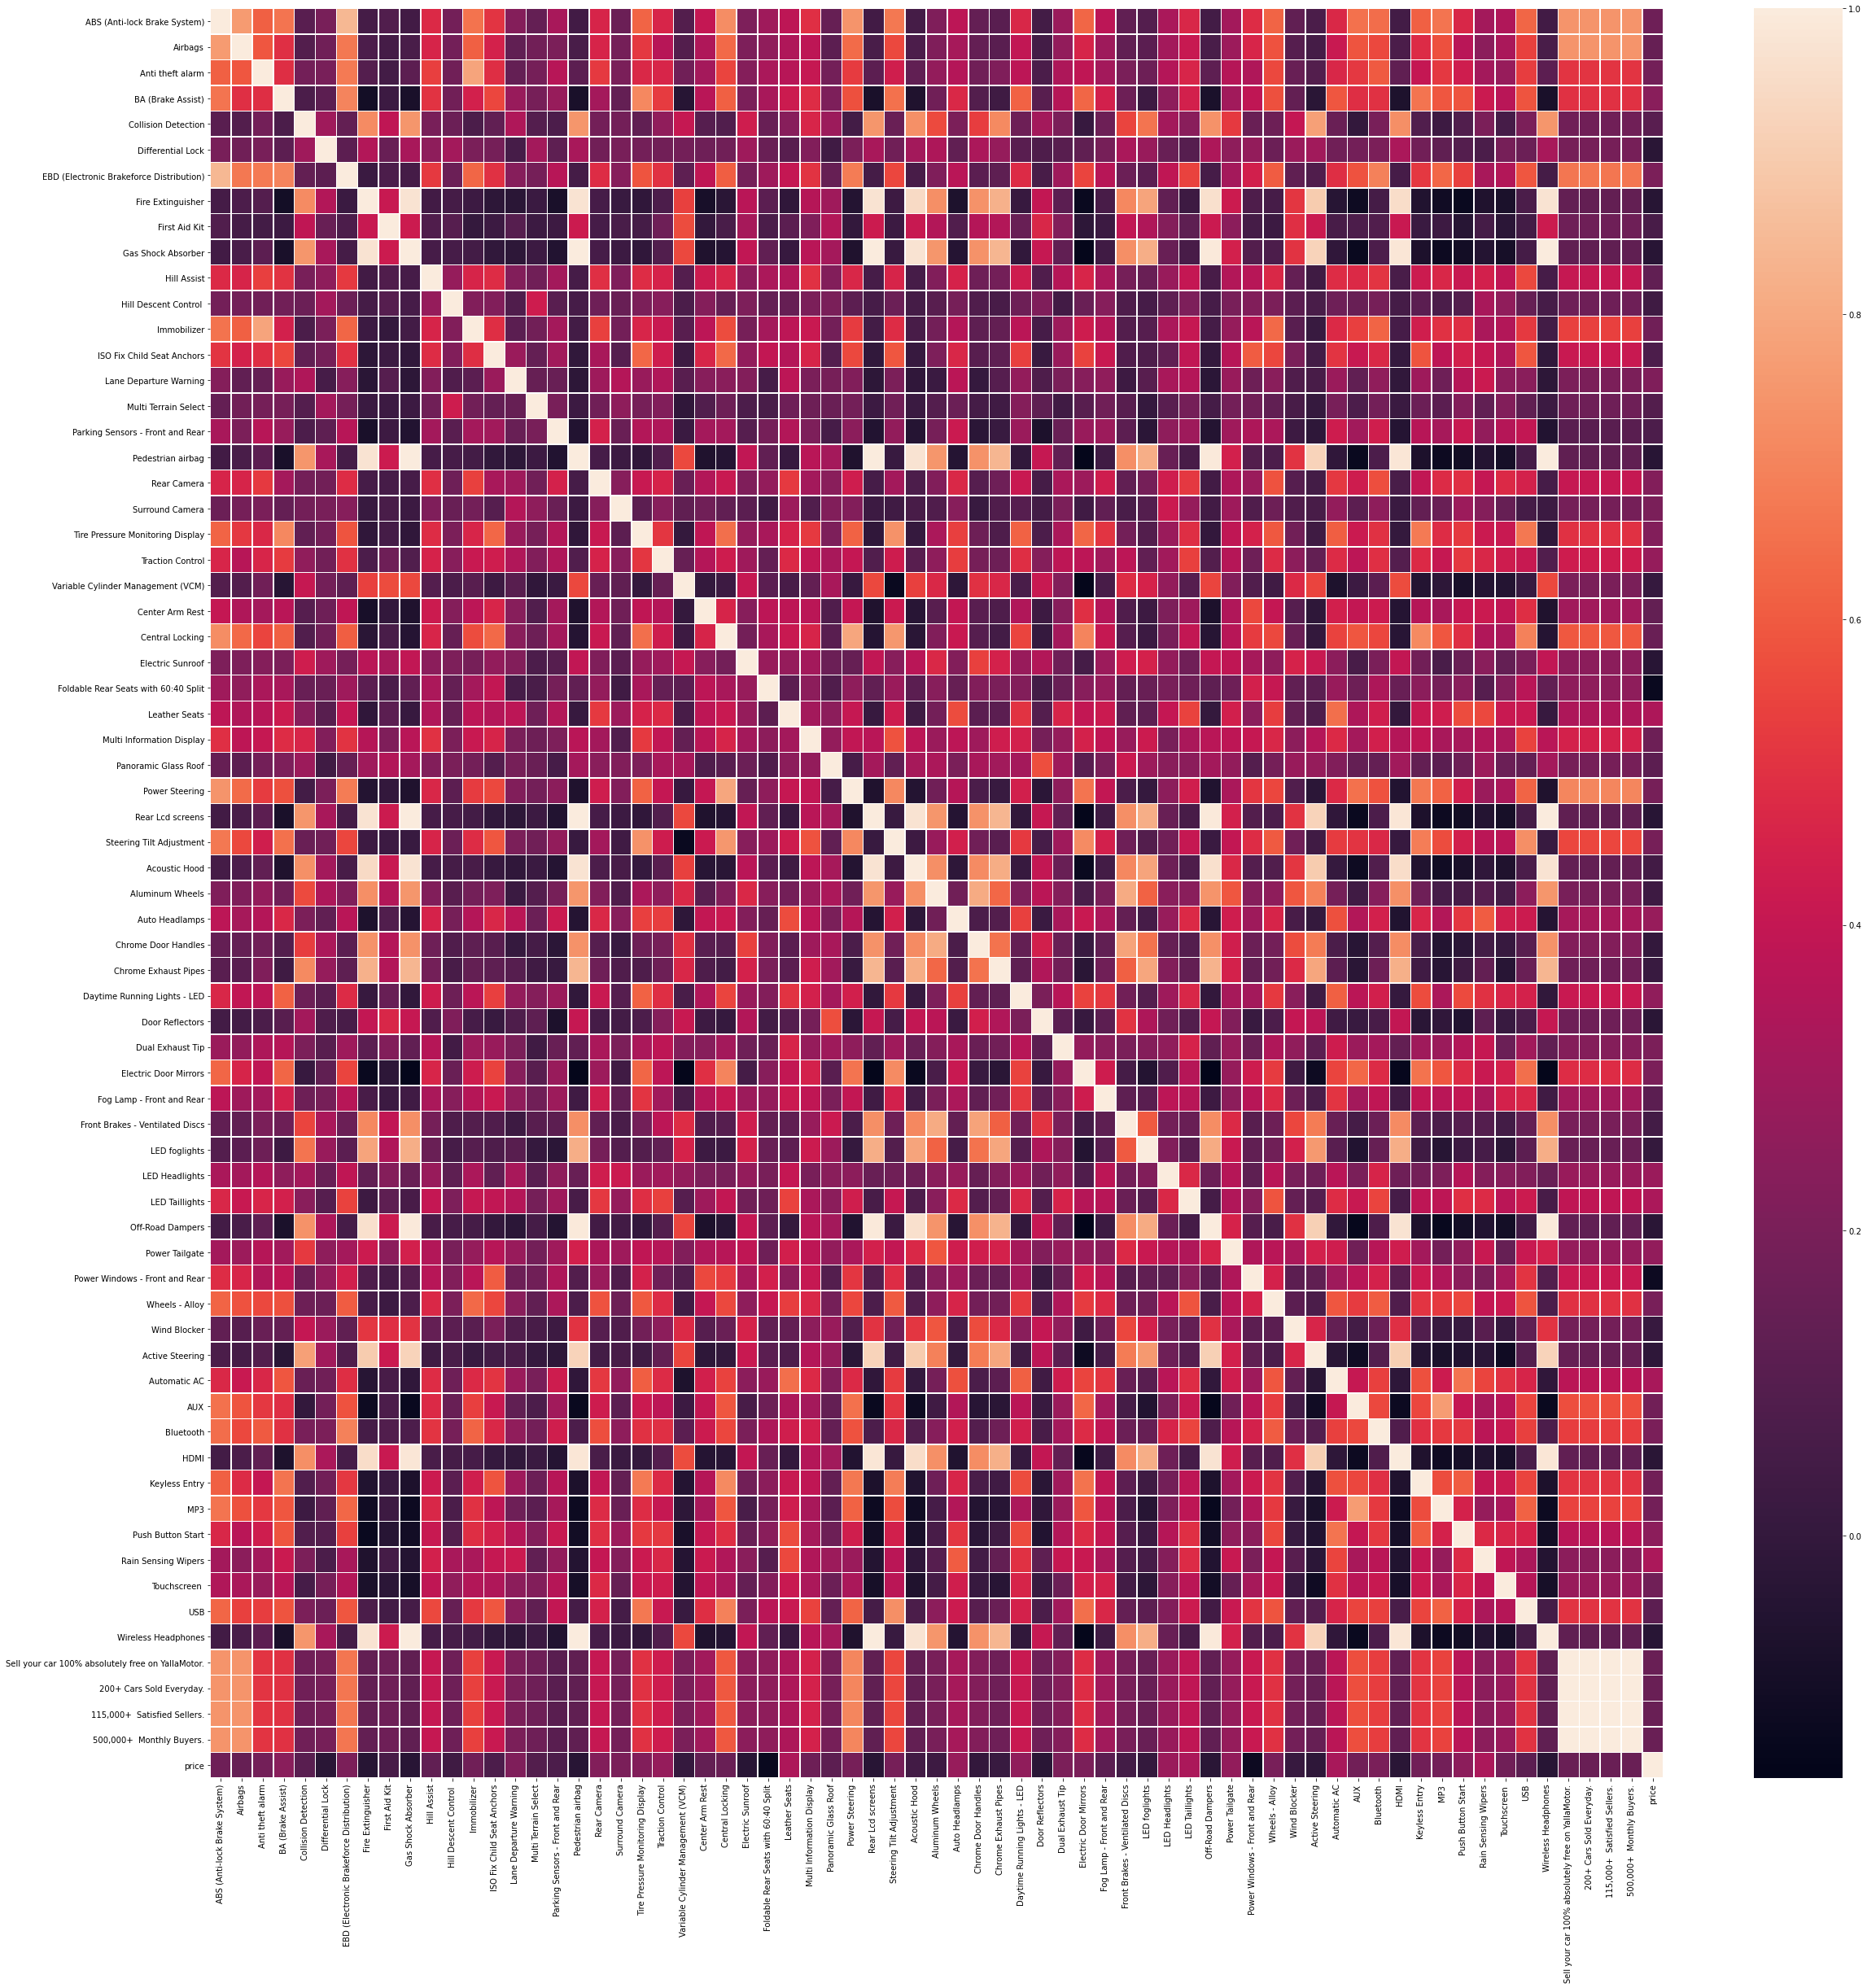

In [76]:
fig, ax = plt.subplots(figsize=(40,40))         # Sample figsize in inches
sns.heatmap(df.corr(), ax=ax, linewidths=0.5);

In [168]:
mvp_df = df[['Collision Detection', 'Gas Shock Absorber']].copy()
mvp_df

,Collision Detection,Gas Shock Absorber
0,-1,-1
1,1,1
2,1,0
3,0,0
4,0,0
...,...,...
268,0,0
269,1,0
270,0,0
271,1,1


## Model

In [169]:
x = mvp_df.iloc[:,:1]
print(x.shape)
x.head()

(273, 1)


,Collision Detection
0,-1
1,1
2,1
3,0
4,0


In [170]:
y = mvp_df.iloc[:, -1:]
print(y.shape)
y.head()

(273, 1)


,Gas Shock Absorber
0,-1
1,1
2,0
3,0
4,0


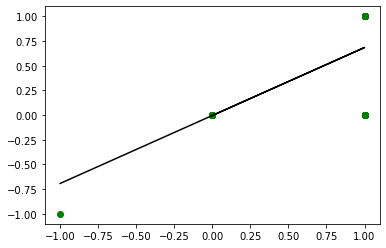

In [171]:
lr = LinearRegression()
lr.fit(x, y)
lr.score(x,y)

plt.scatter(x, y,color='g')
plt.plot(x, lr.predict(x),color='k')
plt.show()

## Conclusion

Most of the features that can give us a general idea about the data requires extensive EDA which will be done in the main project. This is MVP after all. Initial thought about the data shows that some feature engineering might be needed and dropping features which would not help.